In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D


In [2]:
from scipy.integrate import solve_ivp

In [3]:
a = -0.025794
c = 0.02
b1 = 0.0135
b2 = 0.0065
k = 0.129
sigma = 1
alpha = 0.35
eps = 1
beta = 10e-8
q=1.6

In [4]:
def FHN(self, X):
        x1, y1, x2, y2 = X
        return [x1*(a-x1)*(x1-1) - y1 + k*(x2-x1),
                b1*x1 - c*y1,
                x2*(a-x2)*(x2-1) - y2 + k*(x1-x2),
                b2*x2 - c*y2
               ]

In [5]:
def jac(t, X):
    x1, y1, x2, y2 = X
    jacobian = np.zeros((4, 4))
    jacobian[0][0] = -3*x1**2 + 2*a*x1 + 2*x1 - k
    jacobian[0][1] = -1
    jacobian[0][2] = k
    jacobian[1][0] = b1
    jacobian[1][1] = -c
    jacobian[2][0] = k
    jacobian[2][2] = -3*x2**2 + 2*a*x2 + 2*x2 - k
    jacobian[2][3] = -1
    jacobian[1][2] = b2
    jacobian[1][3] = -c
    return jacobian

In [6]:
sol = solve_ivp(FHN, [0, 25000], [-2.24, -3.31, 1.012, 5.123], t_eval=np.array(range(0, 25000, 2)), rtol = 1e-11, atol = 1e-11, dense_output=True)

In [7]:
#sol = solve_ivp(FHN, [0, 10000], [0.1, 0.1, 0.1, 0.1], method='LSODA', first_step=2, max_step=2, jac=jac, 
                # min_step=1.5, dense_output=True)

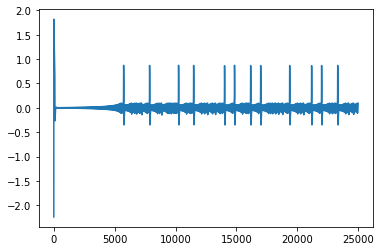

In [8]:
plt.plot(sol.t,sol.y[0])

In [9]:
train = sol.y[0][100:10000]
test = sol.y[0][10000:] 

In [10]:
W_in = np.random.uniform(-sigma, sigma, (1000, 1))

In [11]:
from skimage.io import imshow

In [12]:
def erdos_renyi(n=1000, p=0.6):
    A = np.zeros((n, n))
    for i in range(n):
        for j in range(i, n):
            if np.random.uniform(0, 1) > p:
                a = np.random.uniform(-1, 1)
                A[i][j] = a
                A[j][i] = a
                
        A[i][i] = 0
            
    return A

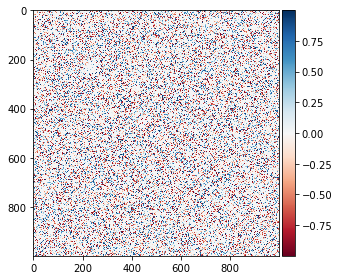

In [13]:
A = erdos_renyi()
imshow(A)

In [14]:
#A = A/np.linalg.eig(A)[0].max()*q

In [15]:
np.linalg.eig(A)[0].max()

22.834470742770375

In [16]:
def reservoir(U):
    r = np.random.uniform(1, -1, (1000, 1))
    R = np.zeros((1000, len(U)))
    R[:, 0] = r[:, 0]
    for i in range(1, len(U)):
        r = (1-alpha)*r + np.tanh(A@r + W_in*U[i] + eps) #U[i] is a number
        R[:, i] = r[:, 0]
    return R

In [17]:
R = reservoir(train)

In [18]:
from sklearn.linear_model import Ridge
reg = Ridge(alpha=beta)
reg.fit(R.T, train)

Ridge(alpha=1e-07)

In [19]:
def reservoir_step(r, v):
    return (1-alpha)*r + np.tanh(A@r + W_in*v + eps)

In [20]:
r = np.expand_dims(R[:, -1], axis=1)
def predict(r, v):
    r = reservoir_step(r, v)
    v_new = reg.predict(r.reshape((1, 1000)))
    return r, v_new

In [21]:
from IPython.display import clear_output


In [22]:
all_rms = []
for M in [10, 20, 25, 30, 40, 45]:
    v = test[0]
    predicted = []
    rms = []
    r = np.expand_dims(R[:, -1], axis=1)
    for i in range(len(test)):
        if i%M == 0 and i != 0:
            rms.append((v-test[i])**2)
            v = test[i]        
        r, v = predict(r, v)
        predicted.append(v)
    all_rms.append(np.mean(rms)**0.5)

In [23]:
all_rms

[0.143261168248311,
 0.18964790640728954,
 0.16165915704723166,
 0.10965065194548798,
 0.2628409588399317,
 0.27917952930145695]

Text(0, 0.5, 'RMS')

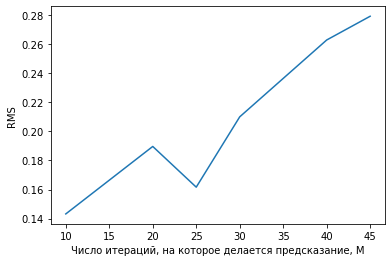

In [28]:
plt.plot([10, 20, 25, 30,  40, 45], all_rms[:3] + [0.21] + all_rms[4:])
plt.xlabel('Число итераций, на которое делается предсказание, M')
plt.ylabel('RMS')

In [ ]:
np.mean(rms)**0.5

In [ ]:
v = test[0]
predicted = []
rms = []
r = np.expand_dims(R[:, -1], axis=1)
for i in range(len(test)):
    if i%10 == 0 and i != 0:
        rms.append((v-test[i])**2)
        v = test[i]        
    r, v = predict(r, v)
    predicted.append(v)

In [ ]:
plt.plot(sol.t[100:10000],reg.predict(R.T))

In [ ]:
plt.plot(sol.t[100:10000], train)

In [ ]:
plt.plot(sol.t[10000:],test)

In [ ]:
plt.plot(sol.t[10000:],predicted)

In [ ]:
plt.plot(sol.t[10000:], predicted)
plt.plot(sol.t[10000:], test)

In [ ]:
def delta(t):
    if t == 0:
        return 1e16
    return 0

In [ ]:
def FHN_with_p(self, X):
    x1, y1, x2, y2 = X
    return [x1*(a-x1)*(x1-1) - y1 + k*(x2-x1),
                b1*x1 - c*y1,
                x2*(a-x2)*(x2-1) - y2 + k*(x1-x2),
                b2*x2 - c*y2
               ]